# **Unsupervised Scalable Representation Learning for Multivariate Time Series**

**Time Series Learning Project**

This notebook implements some of the experiment we did to better understand the main idea of the paper. 

Contains:

* Analysis of the model on Univariate time series (DodgerLoopDay dataset)
* Analysis of the model on Multivariate time series (BasicMotions dataset)

With each time some exploratory experiments.

 The data folder contains the data such that there are: `./data/DodgerLoopDay/DodgerLoopDay_TEST.tsv` and `./data/DodgerLoopDay/DodgerLoopDay_TRAIN.tsv`





# Initialization

In [3]:
%load_ext autoreload
%autoreload 2

import sys
import os
import json
import argparse

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sklearn
import torch
import pytorch_lightning as pl

from datamodule import TimeSeriesDataModule
from model import (Chomp1d, SqueezeChannels, CausalConvolutionBlock, CausalCNN, CausalCNNEncoder)
from train import TimeSeriesEmbedder
from utils import (load_UCR_dataset)
from loss import TripletLoss

root_data = './data/'

# The data folder contains the data such that there are:
# ./data/DodgerLoopDay/DodgerLoopDay_TEST.tsv
# ./data/DodgerLoopDay/DodgerLoopDay_TRAIN.tsv

# Univariate time series 

This section aims at studying the article in the context of univariate time series. As an exploratory example, we used the dataset **DodgerLoopDay **:
    
        "The traffic data are collected with the loop sensor installed on ramp for the 101 North freeway in Los Angeles. This location is close to Dodgers Stadium; therefore the traffic is affected by volume of visitors to the stadium. Missing values are represented with NaN. The classes are days of the week. - Class 1: Sunday - Class 2: Monday - Class 3: Tuesday - Class 4: Wednesday - Class 5: Thursday - Class 6: Friday - Class 7: Saturday."

This section contains:
* Some experiments on our model, dataloader, and loss, on this univariate dataset.

![image.png](imgs/DodgerLoopDay_img.png)

## Training of the Encoder

In [4]:
# Optimization parameters 
batch_size = 20
num_workers = 4
betas = (0.9, 0.999)
weight_decay = 1e-2
lr = 0.001

# Model parameter 
in_channels = 1
channels = 40
depth = 4
reduced_size = 160
out_channels = 320
kernel_size = 3
N_sample = 288

# Data parameters
train_path = os.path.join(root_data,'FordA','FordA_TRAIN.tsv')
val_path = os.path.join(root_data,'FordA','FordA_TEST.tsv')

#train_path = os.path.join(root_data,'DodgerLoopDay','DodgerLoopDay_TRAIN.tsv')
#val_path = os.path.join(root_data,'DodgerLoopDay','DodgerLoopDay_TEST.tsv')


# Datamodule importation
datamodule = TimeSeriesDataModule(train_path, val_path, batch_size, num_workers, min_length=20, multivariate=False, fill_na=True)

# Model definition
model = TimeSeriesEmbedder(
    in_channels = in_channels,
    channels = channels,
    depth = depth,
    reduced_size = reduced_size,
    out_channels = out_channels,
    kernel_size = kernel_size,
    lr=lr,
    weight_decay = weight_decay,
    betas = betas,
    train_path=train_path,
    test_path=val_path
)

In [4]:
epochs = 100
checkpoint_callback = pl.callbacks.ModelCheckpoint(
     mode ='min',
     monitor='train_loss_epoch',
     dirpath='checkpoints',
    filename='causalcnn-{epoch:02d}-{train_loss_epoch:.2f}'
)

wandb_logger = pl.loggers.WandbLogger(project='Self Supervised Time Series Learning', name='Test 1 sur le dataset DodgerLoopDay')
trainer  = pl.Trainer(
    max_epochs=epochs,
    logger = wandb_logger,
    check_val_every_n_epoch=30,
    callbacks = [checkpoint_callback]
)

GPU available: False, used: False
TPU available: None, using: 0 TPU cores


In [ ]:
trainer.fit(model, datamodule)

In [ ]:
fig = trainer.test()

**Classification**

In [ ]:
model.compute_scores()

In [1]:
from datamodule import UnivariateTestDataset
from sklearn.manifold import TSNE
import plotly.express as px


train_set = UnivariateTestDataset(val_path)
embs = model.encoder(torch.Tensor(train_set.time_series[:,None,:])).detach().numpy()
labels = train_set.labels

tsne = TSNE(n_components=2, random_state=21)
projected_emb = pd.DataFrame(np.concatenate((labels[:,None], tsne.fit_transform(embs)), axis=1), columns = ['labels', 'x', 'y'])
projected_emb['labels'] = projected_emb['labels'].astype('int').astype('str')
fig = px.scatter(projected_emb, x = 'x', y='y', color='labels')
fig.write_html("./test_tsne_FordA_without_Train.html", auto_play=True)

KeyboardInterrupt: 

## Run algorithms on all the dataset

In [ ]:
from glob import glob 


dataset_name = []
train_score_list = []
test_score_list = []

for dir_path in glob(os.path.join(root_data,'UCR','*')):
    
    print('Doing {}'.format(os.path.basename(dir_path)))
    train_path = glob(os.path.join(dir_path,'*TRAIN.tsv'))[0] if len(glob(os.path.join(dir_path,'*TRAIN.tsv')))>0 else None
    test_path = glob(os.path.join(dir_path,'*TEST.tsv')) if len(glob(os.path.join(dir_path,'*TEST.tsv')))>0 else None
    
    if train_path is None or test_path is None or os.path.basename(dir_path)=='PigAirwayPressure': 
        continue
    

    # Datamodule importation
    datamodule = TimeSeriesDataModule(train_path, val_path, batch_size, num_workers, min_length=20, multivariate=False, fill_na=True)

    # Model definition
    model = TimeSeriesEmbedder(
        in_channels = in_channels,
        channels = channels,
        depth = depth,
        reduced_size = reduced_size,
        out_channels = out_channels,
        kernel_size = kernel_size,
        lr=lr,
        weight_decay = weight_decay,
        betas = betas,
        train_path=train_path,
        test_path=val_path
    )
    
    epochs = 200
    checkpoint_callback = pl.callbacks.ModelCheckpoint(
         mode ='min',
         monitor='train_loss_epoch',
         dirpath='checkpoints',
        filename='causalcnn-{epoch:02d}-{train_loss_epoch:.2f}')

    wandb_logger = pl.loggers.WandbLogger(project='Self Supervised Time Series Learning', name='ALL EXPERIMENTS - {}'.format(os.path.basename(dir_path)), prefix=os.path.basename(dir_path))
    trainer  = pl.Trainer(
        max_epochs=epochs,
        logger = wandb_logger,
        check_val_every_n_epoch=30,
        callbacks = [checkpoint_callback])
    trainer.fit(model, datamodule)
    fig = trainer.test()
    
    try:
        train_score, test_score = model.compute_scores()
        print('\n', train_score, test_score)
        dataset_name.append(os.path.basename(dir_path))
        train_score_list.append(train_score)
        test_score_list.append(test_score)
    except:
        print('Dataset: {} does not have enough example per class (will fix that)'.format(os.path.basename(dir_path)))
    
results = pd.DataFrame(np.array([dataset_name,train_score_list, test_score_list]).transpose(), columns=['Name', 'Train Accuracy', 'Test Accuracy'])
results.to_csv('./results_univariate_without_training.csv')

Doing Haptics


# Multivariate time series - BasicMotions

This section aims at studying the article in the context of multivariate time series. As an exploratory example, we used the dataset **Basic Motions**:
    
        "The data was generated as part of a student project where four students performed four activities whilst wearing a smart watch. The watch collects 3D accelerometer and a 3D gyroscope It consists of four classes, which are walking, resting, running and badminton. Participants were required to record motion a total of five times, and the data is sampled once every tenth of a second, for a ten second period."

This section contains:
* A visualization of the dataset
* Some experiments on the model provided by the author, on this multivariate dataset

**Importation of the data**

In [8]:
# Load the data
from pyts.datasets import load_basic_motions,uea_dataset_list
X_train, X_test, y_train, y_test = load_basic_motions(return_X_y=True)

**Normalization**

In [9]:
# Preprocessing: normalization
X_train = (X_train - X_train.mean(axis=2)[:,:,None])/X_train.std(axis=2)[:,:,None]
X_test = (X_test - X_test.mean(axis=2)[:,:,None])/X_test.std(axis=2)[:,:,None]


X_train = torch.from_numpy(X_train).double()
X_test = torch.from_numpy(X_test).double()
if torch.cuda.is_available():
    X_train = X_train.cuda()
    X_test = X_test.cuda()

## Visualization

    The data was generated as part of a student project where four students performed four activities whilst wearing a smart watch. The watch collects 3D accelerometer and a 3D gyroscope It consists of four classes, which are walking, resting, running and badminton. Participants were required to record motion a total of five times, and the data is sampled once every tenth of a second, for a ten second period.**


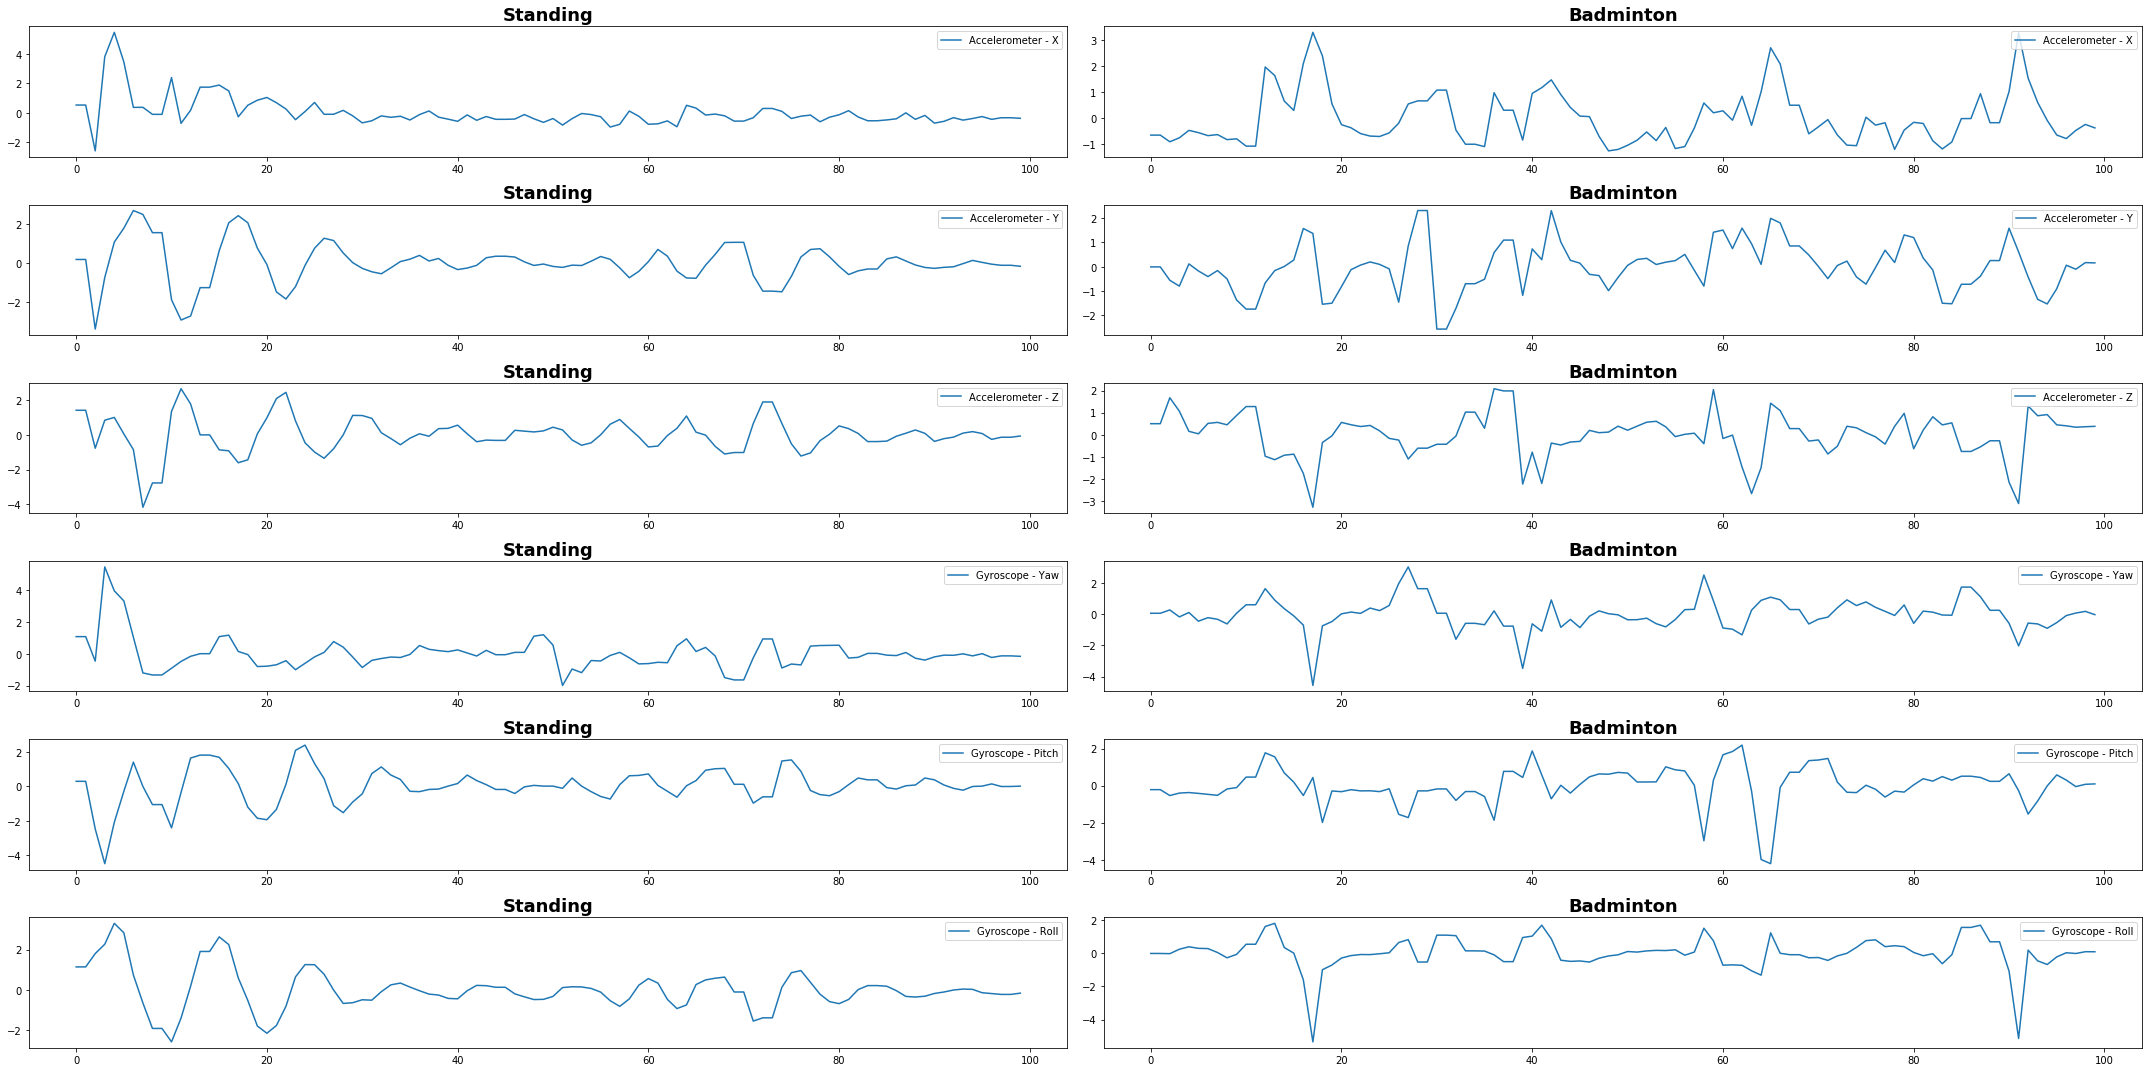

In [10]:
labels = ["Accelerometer - X", "Accelerometer - Y", "Accelerometer - Z", "Gyroscope - Yaw", "Gyroscope - Pitch", "Gyroscope - Roll"]
if True:
    index = 0
    fig = plt.figure(figsize=(30,15))
    axes = []
    for i in range(6):
        axes.append(fig.add_subplot(6,2,2*i+1))
        axes[i].set_title('{}'.format(str(y_train[index])[2:-1]), weight = 'bold', fontsize=18)
        axes[i].plot(X_train[index,i,:], label = labels[i])
        axes[i].legend(loc=1)
    index = -1
    for i in range(6):
        axes.append(fig.add_subplot(6,2,2*(i+1)))
        axes[6+i].set_title('{}'.format(str(y_train[index])[2:-1]), weight = 'bold', fontsize=18)
        axes[6+i].plot(X_train[index,i,:], label = labels[i])
        axes[6+i].legend(loc=1)
plt.tight_layout()

## Causal CNN Encoder - Exploration

This section runs different experiment to investigate the role of the different module of the architecture:

* The global average pooling layer to squeeze the temporal dimension, which is supposed to regularize the model compared to using a fully-connected layer.
* The different hyper-parameters of the model:
        * The depth of the network (i.e the number of causal CNN blocks, e.g 10 by default)
        * The number of channels (e.g 40 by default)


###  Global Average Pooling as a Regularizer

**Model Definition**

In [10]:
in_channels = 6
channels = 40
depth = 4
reduced_size = 160
out_channels = 320
kernel_size = 3
N_sample = 100

# The whole model
causalEncoder = CausalCNNEncoder(in_channels = in_channels, channels = channels, depth = depth,
                                 reduced_size = reduced_size, out_channels = out_channels, kernel_size = kernel_size).double()

# The whole model without the last global average pooling and FC between reduced_size and out_channel
causal_cnn = CausalCNN(in_channels = in_channels, channels = channels, depth = depth, out_channels = out_channels, kernel_size = kernel_size).double()



##### BUILDING EACH BLOCK OF THE MODEL

# Each of the Causal CNN Blocks (of width 4)
ConvBlock_1 = CausalConvolutionBlock(in_channels = in_channels, out_channels = channels, dilation=1, kernel_size=3).double()
ConvBlock_2 = CausalConvolutionBlock(in_channels = channels, out_channels = channels, dilation=2, kernel_size=3).double()
ConvBlock_3 = CausalConvolutionBlock(in_channels = channels, out_channels = channels, dilation=4, kernel_size=3).double()
ConvBlock_4 = CausalConvolutionBlock(in_channels = channels, out_channels = reduced_size , dilation=8, kernel_size=3).double()

# Global average pooling
reduce_size = torch.nn.AdaptiveMaxPool1d(1)

#Squeez the last (third) temporal dimension 
squeeze = SqueezeChannels() 

# last fully connected layer to go from reduced_size to out_channel
linear = torch.nn.Linear(reduced_size, out_channels).double()

**Data shape flow using the global average pooling**

In [11]:
model_from_scratch = [ConvBlock_1, ConvBlock_2, ConvBlock_3, ConvBlock_4, reduce_size, squeeze, linear]
model_name_from_scratch = ['ConvBlock_1', 'ConvBlock_2', 'ConvBlock_3', 'ConvBlock_4', 'Global Average Pooling', 'squeezing', 'final FC']

print('Input Shape:')
print(list(X_train.shape),'\n')
input = X_train
for block_ii in range(len(model_from_scratch)):
    print('{}:'.format(model_name_from_scratch[block_ii]))
    output = model_from_scratch[block_ii](input)
    print(list(output.shape),'\n')
    input = output

Input Shape:
[40, 6, 100] 

ConvBlock_1:
[40, 40, 100] 

ConvBlock_2:
[40, 40, 100] 

ConvBlock_3:
[40, 40, 100] 

ConvBlock_4:
[40, 160, 100] 

Global Average Pooling:
[40, 160, 1] 

squeezing:
[40, 160] 

final FC:
[40, 320] 



**Data shape flow using the a fully-connected layer to squeeze the temporal dimension**

In [12]:
# Instead of the Global Average Pooling
linear_to_squeeze = torch.nn.Linear(N_sample, 1).double()


model_from_scratch_experiment = [ConvBlock_1, ConvBlock_2, ConvBlock_3, ConvBlock_4, linear_to_squeeze, squeeze, linear]
model_name_from_scratch_experiment = ['ConvBlock_1', 'ConvBlock_2', 'ConvBlock_3', 'ConvBlock_4', 'linear_to_squeeze', 'squeezing', 'final FC']

print('Input Shape:')
print(list(X_train.shape),'\n')
input = X_train
for block_ii in range(len(model_from_scratch_experiment)):
    print('{}:'.format(model_name_from_scratch_experiment[block_ii]))
    output = model_from_scratch_experiment[block_ii](input)
    print(list(output.shape),'\n')
    input = output

Input Shape:
[40, 6, 100] 

ConvBlock_1:
[40, 40, 100] 

ConvBlock_2:
[40, 40, 100] 

ConvBlock_3:
[40, 40, 100] 

ConvBlock_4:
[40, 160, 100] 

linear_to_squeeze:
[40, 160, 1] 

squeezing:
[40, 160] 

final FC:
[40, 320] 



**Comparison of the performances**

TODO

### Analysis of the hyperparameters of the model

TODO

# Building the multivariate dataset

In [3]:
train_path = os.path.join(root_data,'DodgerLoopDay','DodgerLoopDay_TRAIN.tsv')
dataset_univariate = UnivariateTrainDataset(train_path, fill_na=True)

In [43]:
from pyts.datasets import load_basic_motions,uea_dataset_list, fetch_uea_dataset
X_train, X_test, y_train, y_test = fetch_uea_dataset('BasicMotions', use_cache=False, data_home='./data/Multivariate/', return_X_y=True)
time_series = X_train
idx=0
min_length = 20
entire_series = time_series[idx]
entire_length = entire_series.shape[1]
pos_length = np.random.randint(min_length, high = entire_length+1)
ref_length = np.random.randint(pos_length, high = entire_length+1)
ref_beg = np.random.randint(0, high = entire_length+1-ref_length)
pos_beg = np.random.randint(ref_beg, high = ref_beg+ref_length-pos_length+1)

ref_series = entire_series[:,ref_beg:ref_beg+ref_length]
pos_series = entire_series[:,pos_beg:pos_beg+pos_length]


In [ ]:
from pyts.datasets import fetch_uea_dataset

class MultivariateTrainDataset(Dataset):
    '''
    Dataset for the Univariate Time series training case. 
    This dataset sample a reference time series and a positive example
    Parameters:
    -----------
        path: str,
            Path to the data file. The time series must be in a tsv format. 
            The fist column correspond to labels and the rest to the time series
        min_length: int, Optional, default=20
            Minimum size of the subsample time series 
    '''
    def __init__(self, dataset, root_data='./data/Multivariate/', min_length=20, fill_na=False):
        super().__init__()
        
        self.time_series, _ , _, _ = fetch_uea_dataset(dataset, use_cache=False, data_home=root_data, return_X_y=True)
        
        if fill_na:
            #print('Percentage of Nan in the training set: {:.2f}\nRemoving nan...'.format(100*np.isnan(self.time_series).sum()/(self.time_series.shape[0]*self.time_series.shape[1])))
            nan_mask = np.isnan(self.time_series)
            self.time_series[nan_mask] = np.zeros(shape=np.count_nonzero(nan_mask))
        self.min_length = min_length
        
    def __getitem__(self, idx):
        entire_series = self.time_series[idx]
        entire_length = entire_series.shape[1]
        
        pos_length = np.random.randint(self.min_length, high = entire_length+1)
        
        ref_length = np.random.randint(pos_length, high = entire_length+1)
        
        ref_beg = np.random.randint(0, high = entire_length+1-ref_length)
        
        pos_beg = np.random.randint(ref_beg, high = ref_beg+ref_length-pos_length+1)
        
        ref_series = entire_series[:,ref_beg:ref_beg+ref_length]
        
        pos_series = entire_series[:,pos_beg:pos_beg+pos_length]
        
        return torch.FloatTensor(ref_series), torch.FloatTensor(pos_series)
        
    
    def __len__(self):
        return self.time_series.shape[1]

# Visualization for the report 

## Univariate

X_train: (78, 1, 288)
y_train: (78,)
X_test: (80, 1, 288)
y_test: (80,)
Percentage of Nan in the training set: 1.0505698005698005


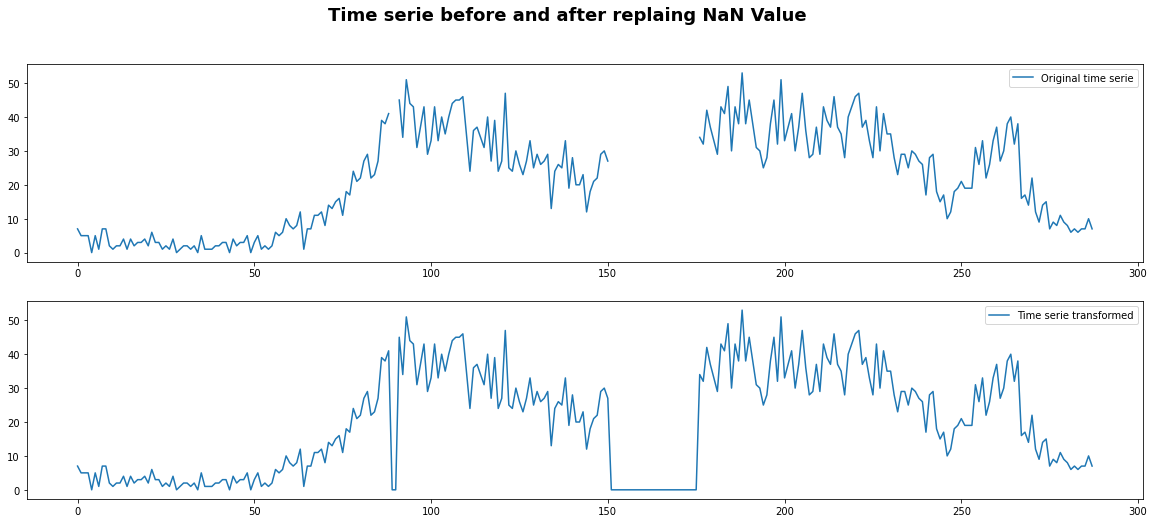

In [24]:
X_train, y_train, X_test, y_test = load_UCR_dataset(root_data,'DodgerLoopDay')

print("X_train: {}".format(X_train.shape))
print("y_train: {}".format(y_train.shape))
print("X_test: {}".format(X_test.shape))
print("y_test: {}".format(y_test.shape))

print('Percentage of Nan in the training set: {}'.format(100*np.isnan(X_train).sum()/(X_train.shape[0]*X_train.shape[2])))
fig,(ax1,ax2) = plt.subplots(2,1, figsize=(20,8))
fig.suptitle('Time serie before and after replaing NaN Value', weight='bold', fontsize=18)
ax1.plot(X_train[16,0,:], label='Original time serie')
nan_mask = np.isnan(X_train)
X_train[nan_mask] = np.zeros(shape=np.count_nonzero(nan_mask))
ax2.plot(X_train[16,0,:], label='Time serie transformed')
ax1.legend()
_ = ax2.legend()

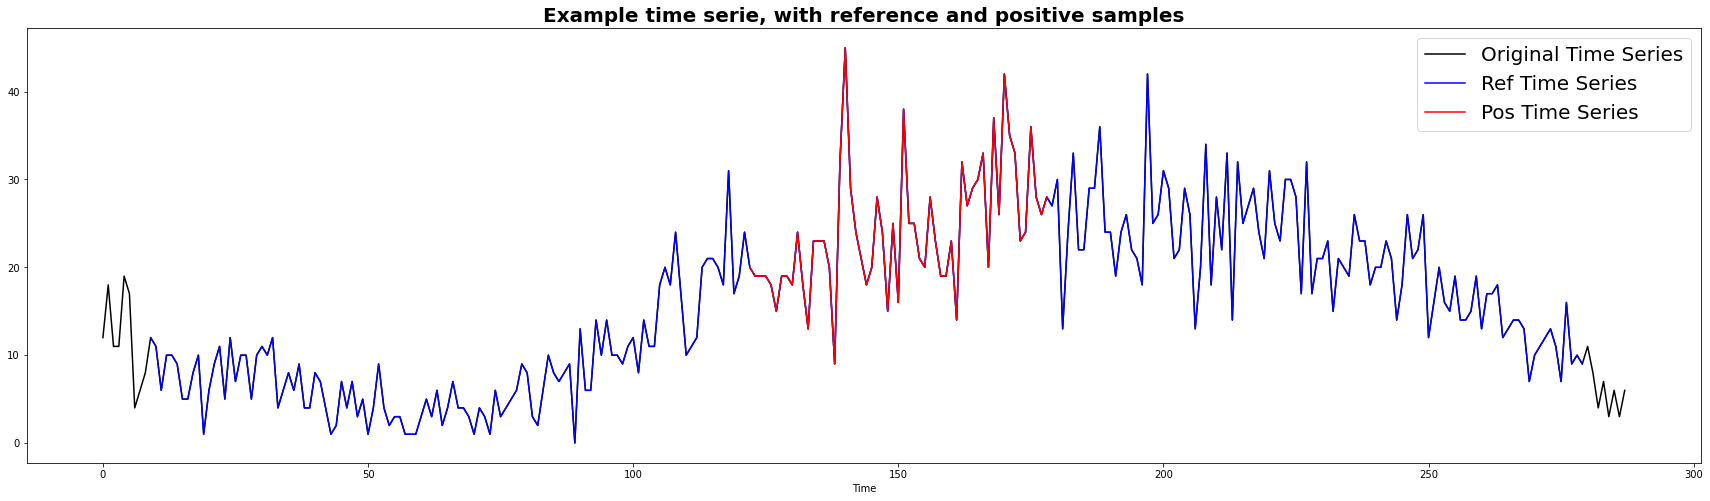

In [46]:
train_path = os.path.join(root_data,'DodgerLoopDay','DodgerLoopDay_TRAIN.tsv')
fill_na = True
min_length = 20

data = pd.read_csv(train_path,sep='\t', header=None)
time_series = np.array(data.iloc[:,1:])

if fill_na:
    #print('Percentage of Nan in the training set: {:.2f}\nRemoving nan...'.format(100*np.isnan(self.time_series).sum()/(self.time_series.shape[0]*self.time_series.shape[1])))
    nan_mask = np.isnan(time_series)
    time_series[nan_mask] = np.zeros(shape=np.count_nonzero(nan_mask))

    
idx=0

entire_series = time_series[idx]
entire_length = entire_series.shape[0]
pos_length = np.random.randint(min_length, high = entire_length+1)
ref_length = np.random.randint(pos_length, high = entire_length+1)
ref_beg = np.random.randint(0, high = entire_length+1-ref_length)
pos_beg = np.random.randint(ref_beg, high = ref_beg+ref_length-pos_length+1)
ref_series = entire_series[ref_beg:ref_beg+ref_length]
pos_series = entire_series[pos_beg:pos_beg+pos_length]

# Visualization
plt.figure(figsize=(30,8))
plt.title('Example time serie, with reference and positive samples', weight='bold', fontsize=20)
plt.plot(entire_series, color='k', label='Original Time Series')
plt.plot(np.arange(ref_beg,ref_beg+ref_length),entire_series[ref_beg:ref_beg+ref_length], color='b', label='Ref Time Series')
plt.plot(np.arange(pos_beg,pos_beg+pos_length),entire_series[pos_beg:pos_beg+pos_length], color='r', label='Pos Time Series')
plt.xlabel('Time')
_ = plt.legend(prop={'size':20})

## Multivariate

ValueError: x and y must have same first dimension, but have shapes (71,) and (0, 100)

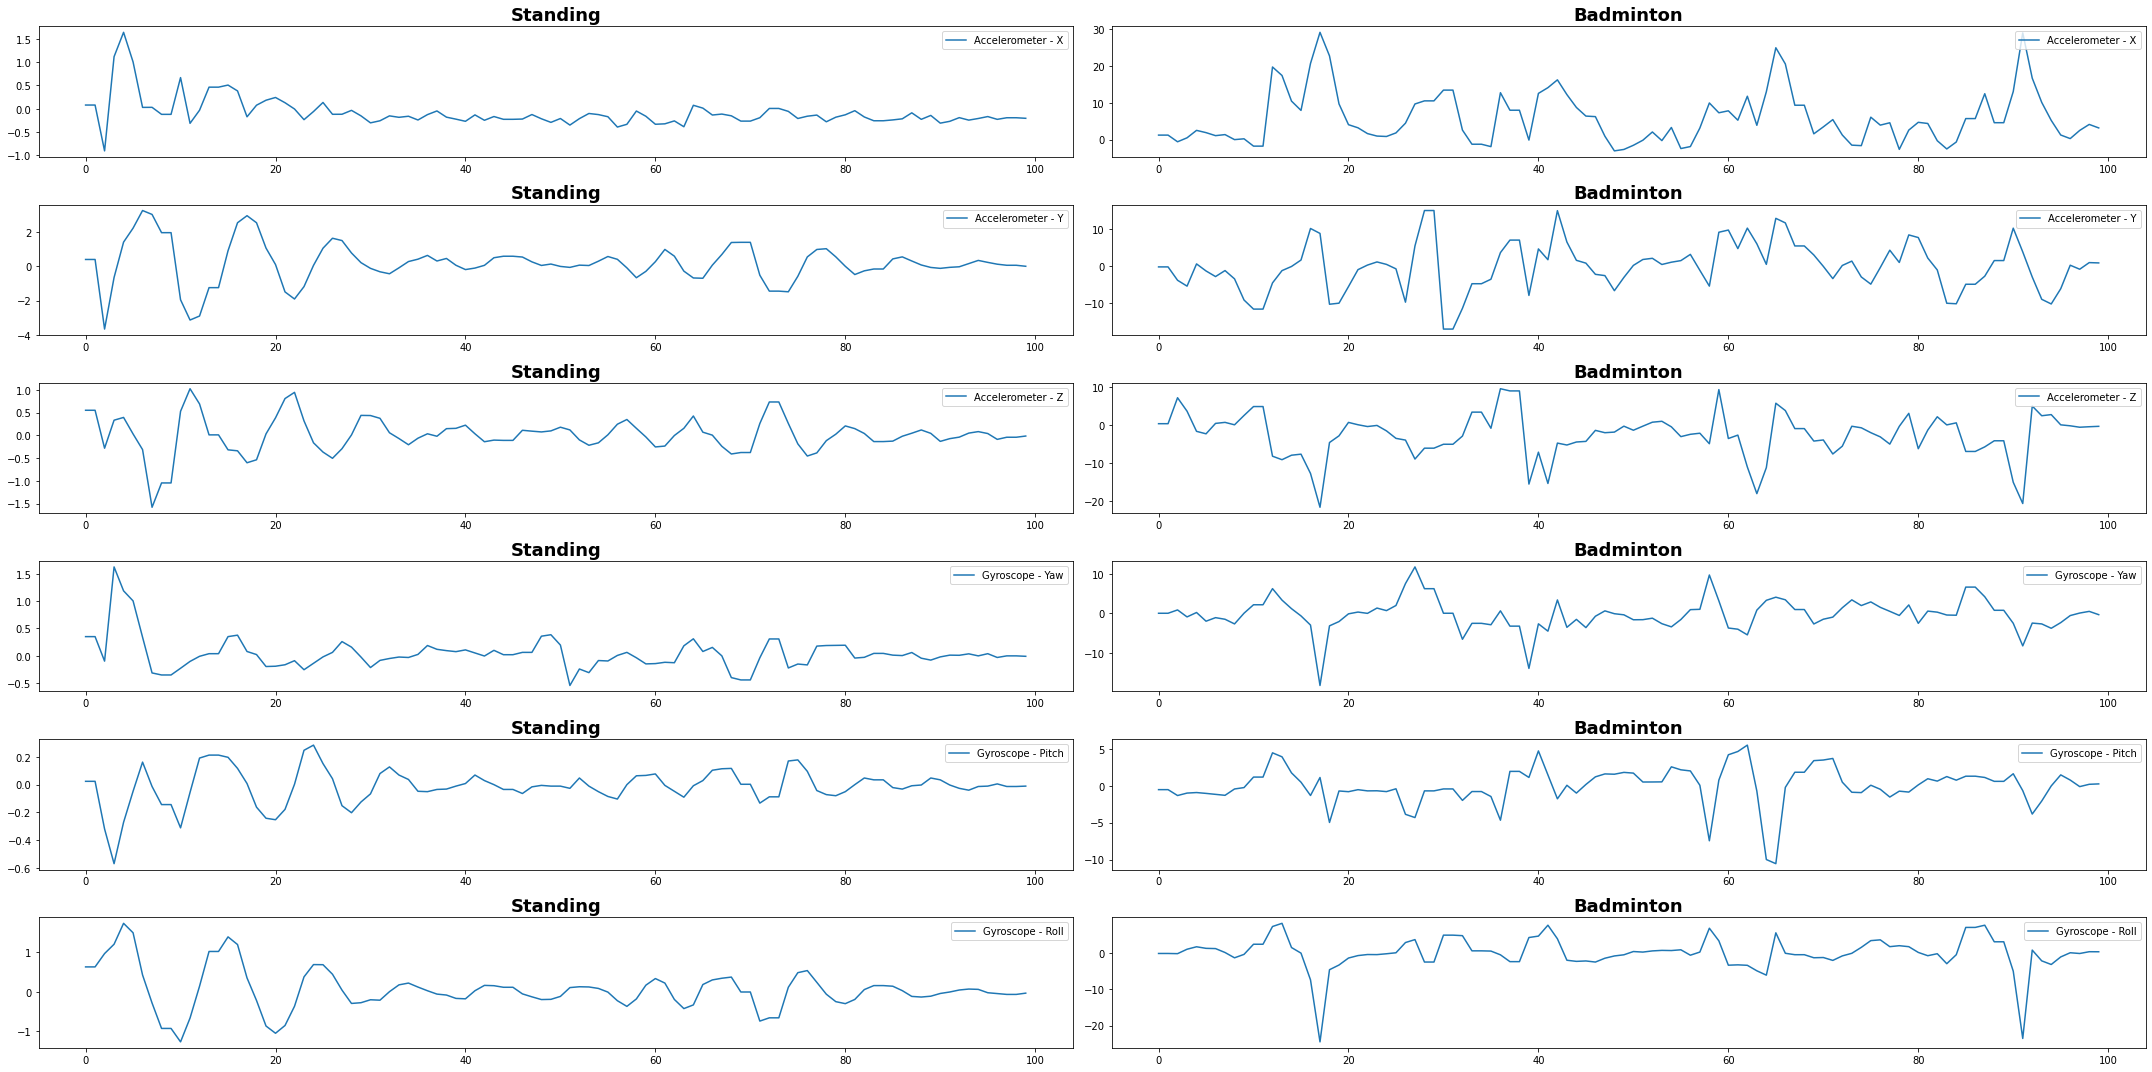

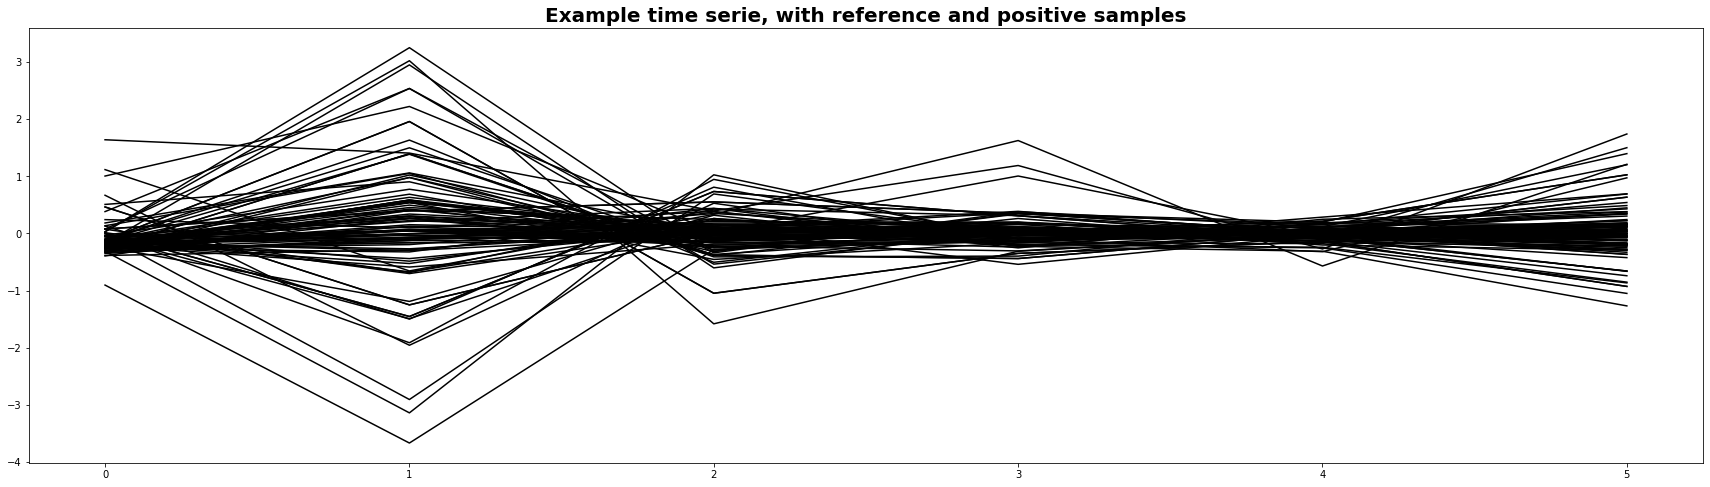

In [47]:
labels = ["Accelerometer - X", "Accelerometer - Y", "Accelerometer - Z", "Gyroscope - Yaw", "Gyroscope - Pitch", "Gyroscope - Roll"]
if True:
    index = 0
    fig = plt.figure(figsize=(30,15))
    axes = []
    for i in range(6):
        axes.append(fig.add_subplot(6,2,2*i+1))
        axes[i].set_title('{}'.format(str(y_train[index])[2:-1]), weight = 'bold', fontsize=18)
        axes[i].plot(X_train[index,i,:], label = labels[i])
        axes[i].legend(loc=1)
    index = -1
    for i in range(6):
        axes.append(fig.add_subplot(6,2,2*(i+1)))
        axes[6+i].set_title('{}'.format(str(y_train[index])[2:-1]), weight = 'bold', fontsize=18)
        axes[6+i].plot(X_train[index,i,:], label = labels[i])
        axes[6+i].legend(loc=1)
plt.tight_layout()


from pyts.datasets import load_basic_motions,uea_dataset_list, fetch_uea_dataset
X_train, X_test, y_train, y_test = fetch_uea_dataset('BasicMotions', use_cache=False, data_home='./data/Multivariate/', return_X_y=True)
time_series = X_train


idx=0
min_length = 20
entire_series = time_series[idx]
entire_length = entire_series.shape[1]
pos_length = np.random.randint(min_length, high = entire_length+1)
ref_length = np.random.randint(pos_length, high = entire_length+1)
ref_beg = np.random.randint(0, high = entire_length+1-ref_length)
pos_beg = np.random.randint(ref_beg, high = ref_beg+ref_length-pos_length+1)

ref_series = entire_series[:,ref_beg:ref_beg+ref_length]
pos_series = entire_series[:,pos_beg:pos_beg+pos_length]



labels = ["Accelerometer - X", "Accelerometer - Y", "Accelerometer - Z", "Gyroscope - Yaw", "Gyroscope - Pitch", "Gyroscope - Roll"]
if True:
    index = 0
    fig = plt.figure(figsize=(30,15))
    axes = []
    for i in range(6):
        axes.append(fig.add_subplot(6,2,2*i+1))
        axes[i].set_title('{}'.format(str(y_train[index])[2:-1]), weight = 'bold', fontsize=18)
        axes[i].plot(X_train[index,i,:], label = labels[i])
        
        axes[i].legend(loc=1)
    index = -1
    for i in range(6):
        axes.append(fig.add_subplot(6,2,2*(i+1)))
        axes[6+i].set_title('{}'.format(str(y_train[index])[2:-1]), weight = 'bold', fontsize=18)
        axes[6+i].plot(X_train[index,i,:], label = labels[i])
        axes[6+i].legend(loc=1)
plt.tight_layout()




# Visualization
plt.figure(figsize=(30,8))
plt.title('Example time serie, with reference and positive samples', weight='bold', fontsize=20)
plt.plot(entire_series, color='k', label='Original Time Series')
plt.plot(np.arange(ref_beg,ref_beg+ref_length),entire_series[ref_beg:ref_beg+ref_length], color='b', label='Ref Time Series')
plt.plot(np.arange(pos_beg,pos_beg+pos_length),entire_series[pos_beg:pos_beg+pos_length], color='r', label='Pos Time Series')
plt.xlabel('Time')
_ = plt.legend(prop={'size':20})
